In [ ]:
"""@article{candido2023image,
  title={Image-Based Detection of Modifications in Assembled PCBs with Deep Convolutional Autoencoders},
  author={Candido de Oliveira, Diulhio and Nassu, Bogdan Tomoyuki and Wehrmeister, Marco Aurelio},
  journal={Sensors},
  volume={23},
  number={3},
  pages={1353},
  year={2023},
  publisher={MDPI}
}"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import exp, pow

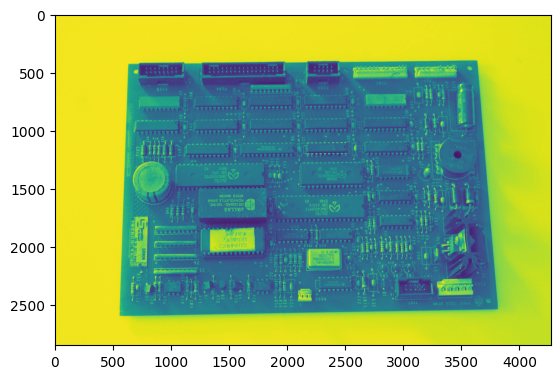

In [2]:
image = cv2.imread("/mnt/DATA/dataset_PCB/original/train/good/0001.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(image)

In [3]:
def generate_gaussian_filter(sigma: int):

    size = int(6 * sigma + 1) if int(6 * sigma) % 2 == 0 else int(6 * sigma)
    filter = np.zeros((size, size))
    sum = 0

    for i in range(size):
        for j in range(size):
            filter[i][j] = (1 / (2 * np.pi * sigma * sigma)) * exp(-((i - size / 2) * (i - size / 2) + (j - size / 2) * (j - size / 2)) / (2 * sigma * sigma))
            sum += filter[i][j]

    for i in range(size):
        for j in range(size):
            filter[i][j] /= sum
    
    return filter

In [4]:
def pyramid_DoG(image, s, level):

    dog_pyramid = []

    for i in range(level):
        sigma = 1.6 * pow(2, i / s)
        k_sigma = 1.6 * pow(2, (i + 1) / s)
        k_filter = generate_gaussian_filter(sigma)
        filter = generate_gaussian_filter(k_sigma)

        k_image_gaussian = cv2.filter2D(image, ddepth=-1, kernel=k_filter)
        image_gaussian = cv2.filter2D(image, ddepth=-1, kernel=filter)
        dog_pyramid.append(k_image_gaussian - image_gaussian)

    return np.stack(dog_pyramid, axis=0)

In [5]:
dog = pyramid_DoG(image=image, s=3, level=5)

In [6]:
def detect_extremum(dog, level, threshold):

    keypoints = []

    for s in range(1, level - 1):
        for x in range(1, dog.shape[1] - 1):
            for y in range(1, dog.shape[2] - 1):
                
                if abs(dog[s][x, y]) < threshold:
                    continue

                neighbors = []
                for ds in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:

                            if dx == 0 and dy == 0 and ds == 0:
                                continue

                            neighbors.append(dog[s + ds][x + dx][y + dy])
                
                if dog[s][x,y] > max(neighbors) or dog[s][x,y] < min(neighbors):
                    keypoints.append((x, y, s))
                    print(x, y, s)
    
    return keypoints

In [7]:
extrema = detect_extremum(dog, 5, 0.03*255)
print(extrema)

1 1539 1
1 3994 1
3 923 1
6 309 1
6 1181 1
7 1267 1
7 1457 1
7 3501 1
7 3878 1
9 4081 1
12 772 1
13 967 1
13 2434 1
14 1239 1
14 1527 1
15 1719 1
16 1240 1
16 1436 1
16 1513 1
16 3453 1
18 1507 1
18 2439 1
18 2455 1
18 3376 1
21 797 1
21 3300 1
22 3495 1
24 2832 1
25 1220 1
26 927 1
28 926 1
29 743 1
29 3320 1
30 554 1
32 4041 1
33 531 1
34 2414 1
34 2912 1
35 821 1
36 1374 1
38 2352 1
38 3417 1
39 583 1
39 2320 1
39 2465 1
40 1357 1
41 3413 1
41 3883 1
42 2351 1
43 742 1
44 1059 1
44 1390 1
45 1680 1
46 1310 1
47 660 1
48 1106 1
49 1325 1
49 3459 1
50 1451 1
51 3476 1
55 767 1
56 1213 1
57 103 1
59 466 1
59 884 1
61 1021 1
62 1030 1
62 2372 1
62 2411 1
64 856 1
65 1099 1
65 1469 1
68 1179 1
68 3263 1
69 3651 1
72 2903 1
73 3161 1
74 2303 1
75 1514 1
76 1156 1
77 1096 1
77 1324 1
78 3374 1
78 3443 1
80 1113 1
80 1346 1
81 716 1
81 741 1
81 3937 1
82 2320 1
82 3448 1
82 3761 1
84 1421 1
84 4142 1
85 925 1
85 1216 1
86 173 1
86 3212 1
86 3230 1
87 3162 1
87 3868 1
88 1346 1
89 1414 1
89 

In [8]:
def hessian(dog, x, y):

    gx, gy = np.gradient(dog)
    gxx, _ = np.gradient(gx)
    _, gyy = np.gradient(gy)
    gxy, _ = np.gradient(gy)

    return np.array([[gxx[x, y], gxy[x, y]], [gxy[x, y], gyy[x, y]]])

In [9]:
def eliminate_edge_keypoints(dog, keypoints, r):
    
    for (x, y, s) in keypoints:

        #hessienne = hessian(dog[s], x, y)
        #trace = (hessienne[0,0] + hessienne[1, 1])
        #determinant = (hessienne[0,0] * hessienne[1, 1] - hessienne[0, 1] ** 2)

        Dxx = cv2.Sobel(dog[s], cv2.CV_64F, 2, 0, ksize=3)
        Dyy = cv2.Sobel(dog[s], cv2.CV_64F, 0, 2, ksize=3)
        Dxy = cv2.Sobel(dog[s], cv2.CV_64F, 1, 1, ksize=3)

        determinant = Dxx[x, y] * Dyy[x, y] - Dxy[x, y] ** 2
        trace = Dxx[x, y] + Dyy[x, y]

        if determinant <= 1e-5:
            continue

        if (((trace ** 2) / determinant) < ((r + 1) ** 2) / r) and (x, y, s) in keypoints:
            keypoints.remove((x, y, s))
            print(x, y, s)

In [10]:
print(len(extrema))
print(dog.shape)
eliminate_edge_keypoints(dog, keypoints=extrema, r=10)
print(len(extrema))

10487
(5, 2848, 4272)


1 1539 1
3 923 1
6 1181 1
7 1457 1
7 3878 1
12 772 1
13 2434 1
14 1527 1
16 1240 1
16 1513 1
18 1507 1
18 2455 1
21 797 1
22 3495 1
25 1220 1
28 926 1
29 3320 1
32 4041 1
34 2414 1
35 821 1
38 2352 1
39 583 1
39 2465 1
41 3413 1
42 2351 1
44 1059 1
45 1680 1
47 660 1
49 1325 1
50 1451 1
55 767 1
57 103 1
59 884 1
62 1030 1
62 2411 1
65 1099 1
68 1179 1
69 3651 1
73 3161 1
75 1514 1
77 1096 1
78 3374 1
80 1113 1
81 716 1
81 3937 1
82 3448 1
84 1421 1
85 925 1
86 173 1
86 3230 1
87 3868 1
89 1414 1
89 4264 1
91 1076 1
91 3857 1
92 3888 1
93 872 1
94 2590 1
96 2016 1
98 3735 1
100 956 1
101 679 1
101 4098 1
102 545 1
102 4161 1
104 4235 1
105 3175 1
106 3525 1
109 579 1
109 2149 1
111 1117 1
113 153 1
113 1339 1
114 1174 1
114 3878 1
116 1178 1
116 3879 1
118 3472 1
120 2197 1
122 4177 1
125 1049 1
125 4167 1
126 3660 1
127 1593 1
128 1211 1
129 4121 1
132 1042 1
134 2691 1
137 925 1
138 1269 1
139 195 1
141 2877 1
144 4056 1
148 1063 1
152 4119 1
153 2648 1
154 4118 1
156 3593 1
159 2279

In [ ]:
def extract_orientation_histogram():

    magnitudes = []
    orientations = []
    for s in range(dog.shape[0]):
        Gx = cv2.Sobel(dog[s], cv2.CV_64F, 1, 0, ksize=3)
        Gy = cv2.Sobel(dog[s], cv2.CV_64F, 0, 1, ksize=3)
        magnitudes.append(np.sqrt(Gx ** 2 + Gy ** 2))
        orientations.append(np.arctan2(Gy, Gx))